# 最主要的更新是加入概率矩阵计算，通过引入t时间，对原来的数据进行采样
- Sliding window sub-trajectory sampling

In [2]:
#!/home/hang/.conda/envs/py37/bin/python
# 导入所需计算库
import sys
import math
import pandas as pd
import numpy as np
import re
import argparse

from scipy import interpolate
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import Rbf

from sklearn.cluster import KMeans
from skimage.feature import peak_local_max

from matplotlib import pyplot as plt
import matplotlib.colors as colors

np.set_printoptions(precision=6)

##########################################################
## Author: IAW
## HENU   
## Cal pmf from 2D
## versin 3.0.beta   
##########################################################

# 定义读取函数
## 返回DataFrame : Frame, Pca1, Pca2
def ReadDat(fp):
    return pd.read_csv(fp,sep = ",",header= None)

# 此函数用于进行时间换算,Frame -> Time
# dt 1帧/ns
def TimeSeries(Frames, dt):
    t = {"ps":[],"ns":[]}
    for i in Frames:
        t["ps"].append(i*dt/1000)
        t["ns"].append(i*dt)
    return t


# 以下是概率密度计算
## 该函数用于生成网格中心点，df: 读取的DataFrame, dnum : 采样网格维度 dnum*dnum
def centerPot(df,dnum):
    x_min,x_max = df[1].min(), df[1].max()
    y_min,y_max = df[2].min(), df[2].max()
    dx = (x_max-x_min) / (2*dnum)
    dy = (y_max-y_min) / (2*dnum)
    x_center = np.array([])
    y_center = np.array([])
    #print("dx = {}, dy = {}".format(dx,dy))
    func = lambda x,d,c0 : (2*x-1)*d + c0
    # 网格面积
    s = 2*dx*2*dy           
    for i in range(1,dnum+1):
        x_center = np.append(x_center,func(i,dx,x_min))
        y_center = np.append(y_center,func(i,dy,y_min))
        #print("x = {} , y  = {} , dx_ = {} , dy_ = {}".format(func(i,dx,x_min),func(i,dy,y_min),(2*i-1)*dx,(2*i-1)*dy))
    return (x_center,y_center,s,dx,dy)

## 该函数用于落在网格中心点的采样点数
# DataSet: list, [Frame,Pca1,Pca]
# 对频率概率密度进行归一化
def CloseWPot(DataSet,center,dx,dy):
    F,x,y = DataSet
    newx = []
    newy = []
    newf = []
    # 用于储存落入网格中的frame信息
    frame = []
    count = 0
    # 遍历寻找落在当前窗格的数据点个数
    for i in range(len(x)):
        if (center[0] - dx <= x[i] <   center[0] + dx) and (center[1] - dy <= y[i] <   center[1] + dy) :
            count += 1
            # 添加符合要求的frame
            frame.append(F[i])
        # 删除统计过的数据点
        else:
            newx.append(x[i])
            newy.append(y[i])
            newf.append(F[i])
    return ([newf,newx,newy],count,frame)

## 用于进行每个窗口的概率密度计算 df: 读取的DataFrame, dnum : 采样网格维度 dnum*dnum
def CountW(df,dnum):

    fxy = [df[0],df[1],df[2]]
    # 总采样点
    N = len(fxy[0])
    cPout = centerPot(df,dnum)
    
    # 生成的中心网格点是一个方阵
    x_center,y_center,s,dx,dy = cPout
    z_center = np.zeros([len(x_center),len(y_center)])

    # 创建dict储存采样网格原始frame信息，其中keys的格式为"i-j"
    f_center = {}
    print("")
    print("Ready to cal P")
    print("S_window={:.2f}\t\tN_total={}".format(s,N))
    
    for i in range(len(x_center)):
        for j in range(len(y_center)):
            cwPout = CloseWPot(DataSet = fxy
                                        ,center = (x_center[i],y_center[j])
                                        ,dx = dx
                                        ,dy = dy
                                    )
            # 更新fxy
            fxy = cwPout[0]
            # 计算该点的概率密度
            P = cwPout[1] / (N*s)
            # 可能会出现大于1的情况
            if P > 1:
                print("Warning P > 1")
                print("P({},{})={}\nx={},y={}\ncount={},N={},s={}".format(i,j,P,x_center[i],y_center[j],cwPout[1],N,s))
            # 记录数值
            z_center[i][j] = P
            # 因为下一步转至了，所以这一步是j i
            f_center["{}-{}".format(j,i)] = cwPout[2]
    # 最后生成的z需要转置
    z_center = z_center.T
    print("Pmax-ori={},Pmin-ori={}".format(z_center.max(),z_center.min()))
    # 归一化
    tol_density = np.sum(z_center)
    z_center /=tol_density
    print("After Normalization, Pmax={},Pmin={}".format(z_center.max(),z_center.min()))
    print("")
    return (x_center,y_center,z_center,f_center)

# 以下是绘图部分
## 全局字体设置
plt.rcParams["axes.labelweight"] ="bold"
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.weight"]="bold"
plt.rcParams["font.size"]=20

def draw2DGibbs(xyz,cname,peak, outname, xlabel, ylabel):
    # 绘制概率密度曲线
    X,Y,Z = xyz
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.set_xlim(X.min(),X.max())
    ax.set_ylim(Y.min(),Y.max())
    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))
    C=plt.contour(X,Y,Z,5,colors='black',linewidths= 0.2)  #生成等值线图
    plt.contourf(X,Y,Z,5,alpha=0.2)
    Pcolor= plt.pcolor(X, Y, Z
                       ,shading='auto',cmap=cname
                       ,norm = colors.TwoSlopeNorm(vmin=Z.min(), vcenter=(Z.max()-Z.min())/2, vmax=Z.max()))
    plt.colorbar(Pcolor)
    plt.scatter(peak.x,peak.y,color = "black",s = 6)

    plt.savefig("{}.jpg".format(outname))

## 用于绘制散点分布，以及cutoff的截断圆
def draw2DScatterCircle(df,slabel,myPeak, cutoff, outname,xlabel,ylabel):
    dat = df.copy()
    dat[3] =  slabel
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))

    ax.set_xlim(dat[1].min(),dat[1].max())
    ax.set_ylim(dat[2].min(),dat[2].max())
    for i in set(slabel):
        Datai = dat[dat[3] == i]
        plt.scatter(Datai[1],Datai[2],alpha = 0.7,s= 5)
    # 绘制峰值点:
    for i,x_ in enumerate(myPeak.x):
        plt.scatter(x_,myPeak.y[i],color = "black")
        plt.text(x_,myPeak.y[i],s="P{}".format(i))
        # 并绘制cutoff
        draw_circle = plt.Circle((x_,myPeak.y[i]),cutoff,fill=False)
        plt.gcf().gca().add_artist(draw_circle)

    #plt.savefig("{}.tiff".format(outname))
    plt.savefig("{}.jpg".format(outname))
    
    #plt.show()

## 用于绘制散点-时间分布
def draw2DScatterTime(df, outname,Time,xlabel,ylabel):
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))
    ax.set_xlim(df[1].min(),df[1].max())
    ax.set_ylim(df[2].min(),df[2].max())
    plt.scatter(df[1],df[2],alpha = 0.7,s= 5,c=Time["ns"])
    cbar = plt.colorbar()
    cbar.set_label('Time (ns)')
 
    plt.savefig("{}.tiff".format(outname))
    plt.savefig("{}.jpg".format(outname))
    

# 峰值点部分
# 注意，del需要在计算G之后调用，切记
class PPeak():
    def __init__(self,n_peak,DATA) -> None:
        self.x = []
        self.y = []
        self.DATA = DATA
        self.ij = peak_local_max(self.DATA[2],num_peaks=n_peak)
        self.G = []
        self._xy()
    def _xy(self):
        for i in range(self.ij.shape[0]):
            self.x.append(self.DATA[0][self.ij[i,1]])
            self.y.append(self.DATA[1][self.ij[i,0]])
    # 用于删除指定索引
    def delPeak(self,i_list):
        x = []
        y = []
        G = []
        ij = np.empty(shape=[0, 2],dtype="int")
        for i,x_ in enumerate(self.x):
            if i not in i_list:
                x.append(x_)
                y.append(self.y[i])
                G.append(self.G[i])
                ij = np.append(ij,values=[self.ij[i]], axis=0)
        self.x = x
        self.y = y
        self.ij = ij
        self.G = G
    def _g(self,G):
        self.G = G
# 用于从终端获取哪些峰值点需要被删除
def GInDelPeakIndex():
    ss = input("Index: ")
    s = ss.rstrip("\n").split(",")
    out = [eval(i) for i in s]
    return out

# 此函数用于从一系列frame中寻找一个最合适的Rep，首先进行3σ准则，排除异常值，再进行从小到大的排序，如果是偶数，取(len - 1 )//2，如果是奇数取 (len - 1) / 2
# 新增功能，用于计算去除异常值之后的Frames的平均值，这里不做取整，主要表示时间，同时返回最小值，最大值
# 定义数据包用于FindPeakRep函数
class CircleData():
    def __init__(self,rep,ave_,max_,min_):
        self.rep = rep
        self.ave = ave_
        self.ma = max_
        self.mi = min_        

def FindPeakRep(Frames):
    new = []
    exceptnum = []
    mean_ = sum(Frames) / len(Frames)
    std = np.std(np.array(Frames))
    up = mean_ + 3*std
    limit = mean_ - 3*std
    for i,x in enumerate(Frames):
        if (x >  up) or (x <  limit):
            exceptnum.append(x)
        else:
            new.append(x)
    if (len(new) - 1)%2 != 0:
        var = len(new) - 2          # 偶数个
    else:
        var = len(new) - 1          # 奇数个

    rep = new[int(var/2)]
    ave = sum(new)/len(new)
    min_ = min(new)
    max_ = max(new)
    myCircleData = CircleData(rep,ave,max_,min_)
    return myCircleData

## 采用KNN分类用于对峰值周围的点进行分类
### ct_x : 储存中心点的x坐标 ct_y ：储存中心点的y坐标 DATA: 储存待分类数据，数据结构为pandas
### 引入cutoff : 用于只保留峰值点周围多少距离的数据
def KNN(ct_x,ct_y,DATA,cutoff):
    label = []
    dist = []
    for i in range(DATA.shape[0]):
        fi = DATA.iloc[i,0]
        xi = DATA.iloc[i,1]
        yi = DATA.iloc[i,2]
        d = {}
        Fd = lambda x0,y0,x1,y1: math.sqrt(math.pow(x1 - x0, 2) + math.pow(y1 - y0, 2)) 
        for i_,x_ in enumerate(ct_x):
            d[str(i_)] = Fd(x_,ct_y[i_],xi,yi)
        d_ = sorted(d.items(),  key=lambda d: d[1], reverse=False)[0]
        labeli = eval(d_[0])
        label.append(labeli)
        disti = d_[1]
        if disti <= cutoff:
            dist.append(1)
        else:
            dist.append(0)
        
    return (label,dist)



## 此函数用于计算KNN聚类中，每隔cutoff circle中的数据frame信息
## DATA 最原始数据，lable KNN返回的， cutbool: KNN返回，标志是否位于阶段之中
def CTinfo(DATA, label, cutbool):
    out = []
    Data = DATA.copy()
    Data[3] = label
    Data[4] = cutbool
    for i in set(label):
        out.append(FindPeakRep(list(Data.loc[(Data[3] == i) & (Data[4] == 1),:][0])))
    return out
# 此函数用于返回KNN聚类中，每个cutoff circle中的数据frame信息
def CTframe(DATA, label,cutbool):
    out = {}
    Data = DATA.copy()
    Data[3] = label
    Data[4] = cutbool
    for i in set(label):
        out[str(i)] = list(Data.loc[(Data[3] == i) & (Data[4] == 1),:][0])
    return out


## 定义函数用于输出CTinfo的信息
def PrintCTinfo(CTinfo_out, mypeak,dt):
    for i,x_ in enumerate(mypeak.x):
        print("P{}:".format(i))
        print("Frame: Rep = {}, Ave = {}, Range: {} -> {}".format(CTinfo_out[i].rep,CTinfo_out[i].ave,CTinfo_out[i].mi,CTinfo_out[i].ma))
        print("Time: Ave = {:.2f} (ns), Range: {:.2f} -> {:.2f} (ns)".format(CTinfo_out[i].ave*dt,CTinfo_out[i].mi*dt,CTinfo_out[i].ma*dt))
        print("Gibbs = {:.2f}".format(mypeak.G[i]))
        print("")

# 定义函数用于输出CTframe信息
# 因为frame是从1开始，所以输出索引的时候直接-1就好，也就是需要一个参数sF：
def PrintCTframe(CTframe_out, sF,outf):
    with open(outf, "w+") as F:
        for i in CTframe_out.keys():
            F.writelines("P{}:\n".format(i))
            var = [ str(f - sF) for f in CTframe_out[i]]
            F.writelines(",".join(var)+"\n")
            F.writelines("END\n".format(i))
        
        

# 自由能计算模块
# 该函数用于计算相对的Gibbs
# 修订, 新增计算峰值点的Gibble
def CalGibbs(P_martix, Peak, T):                        # 20230616 T参数新增
    k = 1.3806505*10**(-23)
    C = 0 
    c1 = 4186
    NA = 6.023*10**(23)                                 # 20230426: SB ......... kT ->kcal/mol
    # flatten
    shape = P_martix.shape
    P_ = P_martix.flatten()
    
    
    # 概率密度为0的密度点的Gibbs会直接变为0,P < 1，所以
    Gibbs = lambda P: np.nan if abs(P - 0) <= 1e-10  else ((-k*T*np.log(P) + C)/c1)*NA
    G = np.array(list(map(Gibbs,P_))).reshape(shape)
    var = G[~np.isnan(G)]
    G_min = var.min()
    G_max = var.max()
    # 这一步是为了让概率密度最大处的G为0，计算完毕后，需要再计算一次max,min
    G = G-G_min
    var = G[~np.isnan(G)]
    G_min = var.min()
    G_max = var.max()

    G = np.nan_to_num(G, nan=G_max + (G_max-G_min)/10)
    
    # 提取Peak中的峰值点的G
    ij = Peak.ij
    g_peak = []
    for i in range(ij.shape[0]):
        g_peak.append(G[ij[i,0],ij[i,1]])
 
    print("G_max={:.2f},G_min={:.2f},GnoSample(Nan)={:.2f},Gmax_nonan={:.2f} ".format(G_max,G_min,G_max + (G_max-G_min)/10,G.max()))
    print("")
    return G,g_peak

## 此函数用于插值
# 采用griddata进行插值
def InterNUM_ggd(XX,YY,Z,x,y,Gridnum):
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()
    xx,yy = np.meshgrid(np.linspace(xmin,xmax,num = Gridnum,endpoint=True),np.linspace(ymin,ymax,num = Gridnum,endpoint=True))
    newz = interpolate.griddata((XX.flatten(),YY.flatten()),Z.flatten(),(xx,yy), method='linear',fill_value =0)

    return (xx,yy,newz)

def G_InterNUM_ggd(myP,Gridnum,Gibbs):
    # 根据网格密度生成网格
    X,Y = np.meshgrid(myP[0],myP[1])
    Z = Gibbs
    # 进行GIBBS计算
    print("Gibbs_MAX={:.2f},Gibbs_MIN={:.2f}".format(Z.max(),Z.min()))
    print("Gibbs InterNUM_ggd:")
    X,Y,Z = InterNUM_ggd(X,Y,Z,myP[0],myP[1],Gridnum)
    print("Gibbs_MAX={:.2f},Gibbs_MIN={:.2f}".format(Z.max(),Z.min()))
    pd.DataFrame([X.flatten(),Y.flatten(),Z.flatten()]).T.to_csv("G_InterNUM_mgd.csv")
    return (X,Y,Z)



# 新增参数输入文件
def Parm():
    parser = argparse.ArgumentParser(description=
                                     "The author is very lazy and doesn't want to write anything\n"
                                     "Author: ZJH [HENU]"
                                    )
    parser.add_argument("-Fp",type=str, nargs=1, help="File Path")
    parser.add_argument("-dim",type=str, nargs=1, help="dim")
    parser.add_argument("-Smo",type=str, nargs=1, help="Smooth")
    parser.add_argument("-T",type=str, nargs=1, help="Temperature (K)")
    parser.add_argument("-Cutoff",type=str, nargs=1, help="Cut off")
    parser.add_argument("-Pn",type=str, nargs=1, help="The num of Peaks")
    parser.add_argument("-dt",type=str, nargs=1, help="Time scale")
    parser.add_argument("-Cmp",type=str, nargs=1, help="Color")
    parser.add_argument("-Xlab",type=str, nargs=1, help="Xlabel")
    parser.add_argument("-Ylab",type=str, nargs=1, help="Ylabel")
    return parser.parse_args()



Ready to cal P
S_window=0.02		N_total=84000
Pmax-ori=0.7890406474537236,Pmin-ori=0.0
After Normalization, Pmax=0.013166980166194435,Pmin=0.0

Start to draw PCA-T figure and it will be saved as PCA-T.jpg


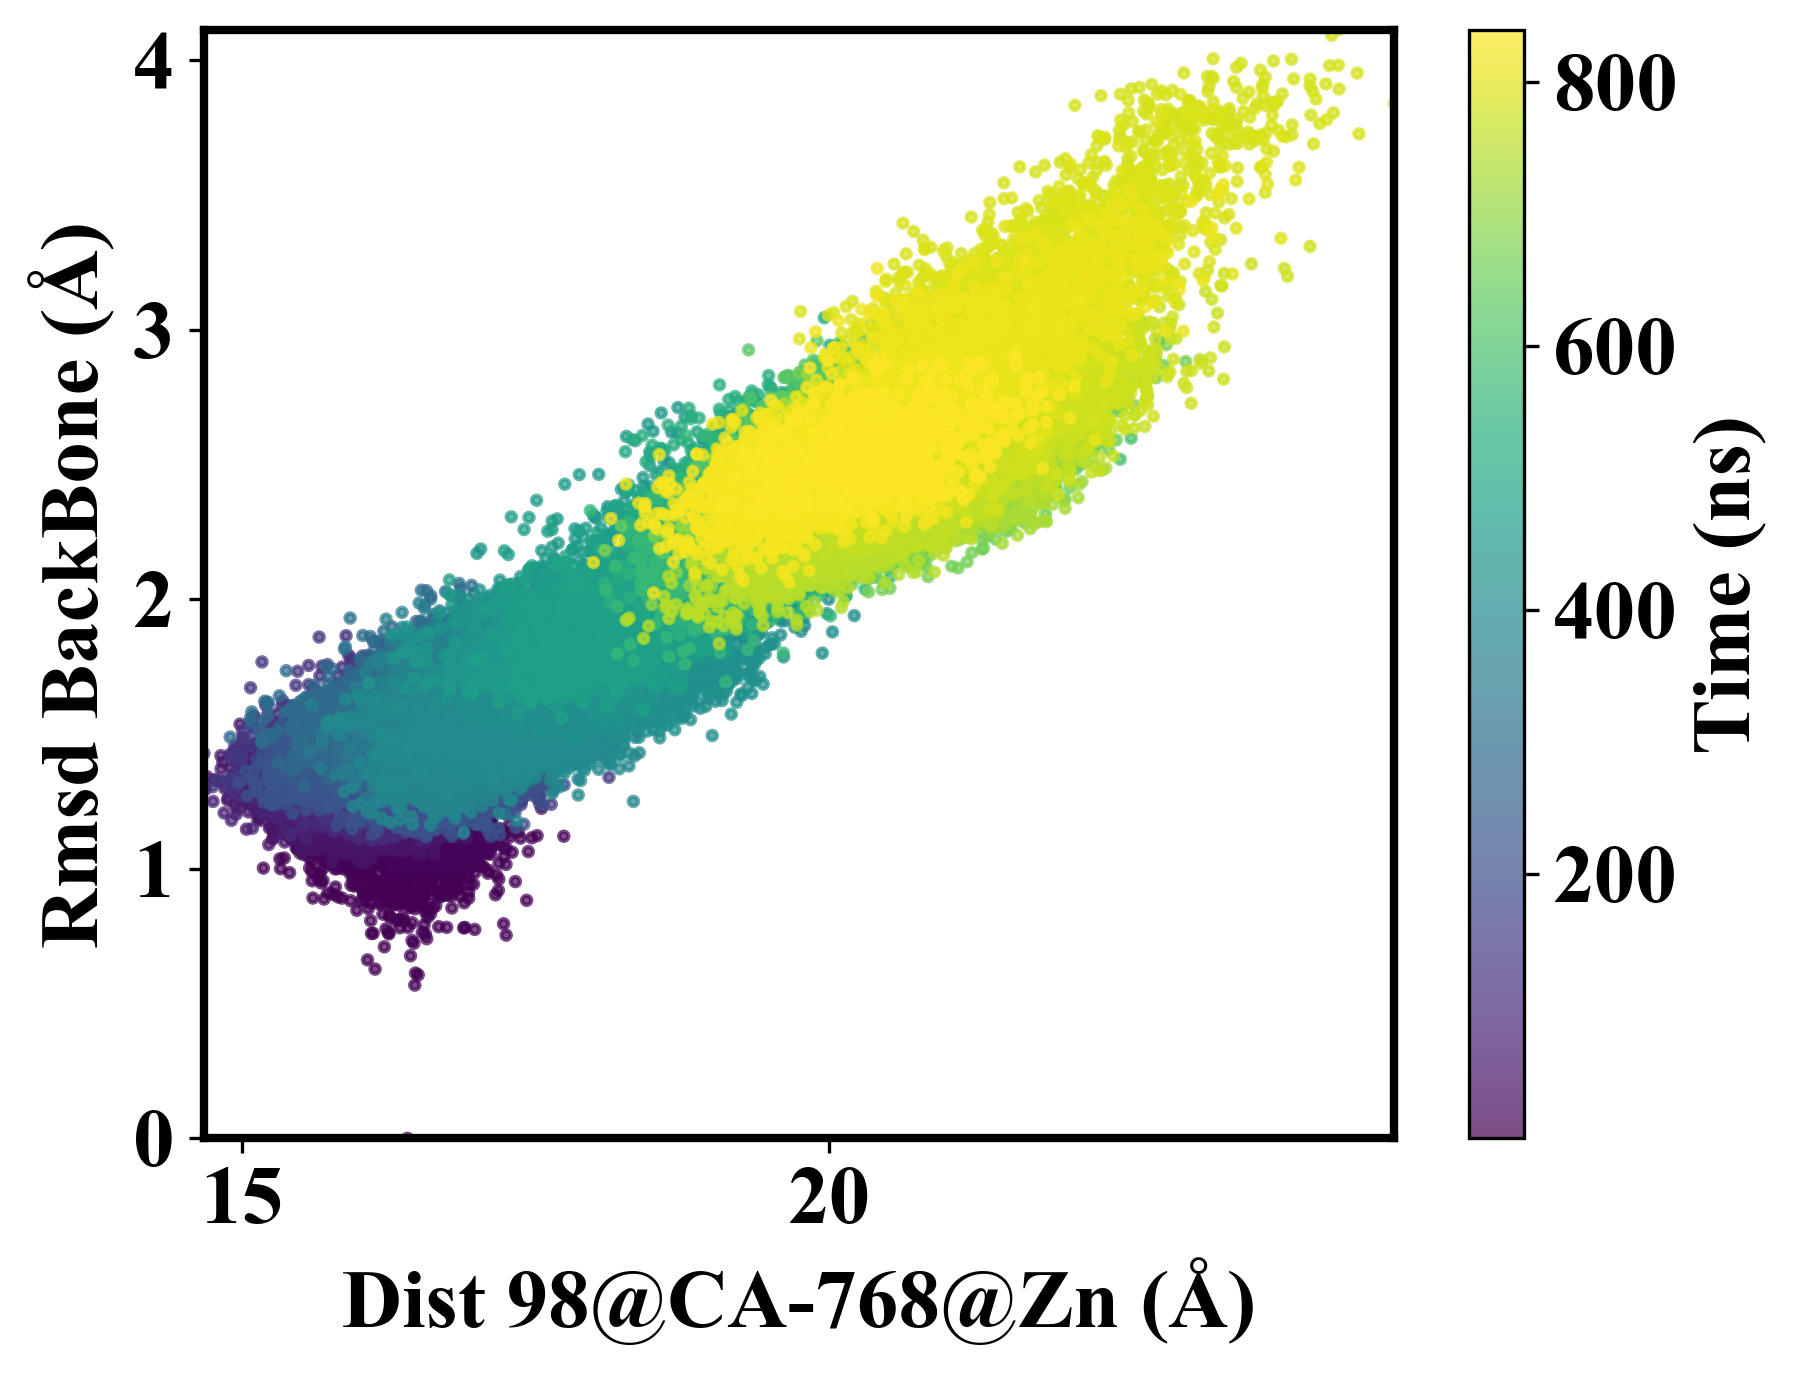

In [45]:
fp = "./all.csv"                             
dnum = 50                       
dt = 0.01
Gridnum = 500
n_peak = 5          
cutoff = 0.2  
T = 300
mycmp = "rainbow"                          
xlabel = "Dist 98@CA-768@Zn (Å)"
ylabel = "Rmsd BackBone (Å)"
df = ReadDat(fp)
time = TimeSeries(df[0], dt)
myP = CountW(df,dnum)
print("Start to draw PCA-T figure and it will be saved as PCA-T.jpg")
draw2DScatterTime(df, "PCA-T",time,xlabel,ylabel)

In [48]:
print("Start of peak analysis of probability density")
myPeak = PPeak(n_peak,myP[:3])
print("KNN Classification...")
slabel_0,scut_0 = KNN(myPeak.x,myPeak.y,df,cutoff)
print("The summary of Peak Aalysis will be show as PCA-Peak-KNN.jpg\nAnd you should tell me the index of peak ,which should be delete")

Start of peak analysis of probability density
KNN Classification...
The summary of Peak Aalysis will be show as PCA-Peak-KNN.jpg
And you should tell me the index of peak ,which should be delete


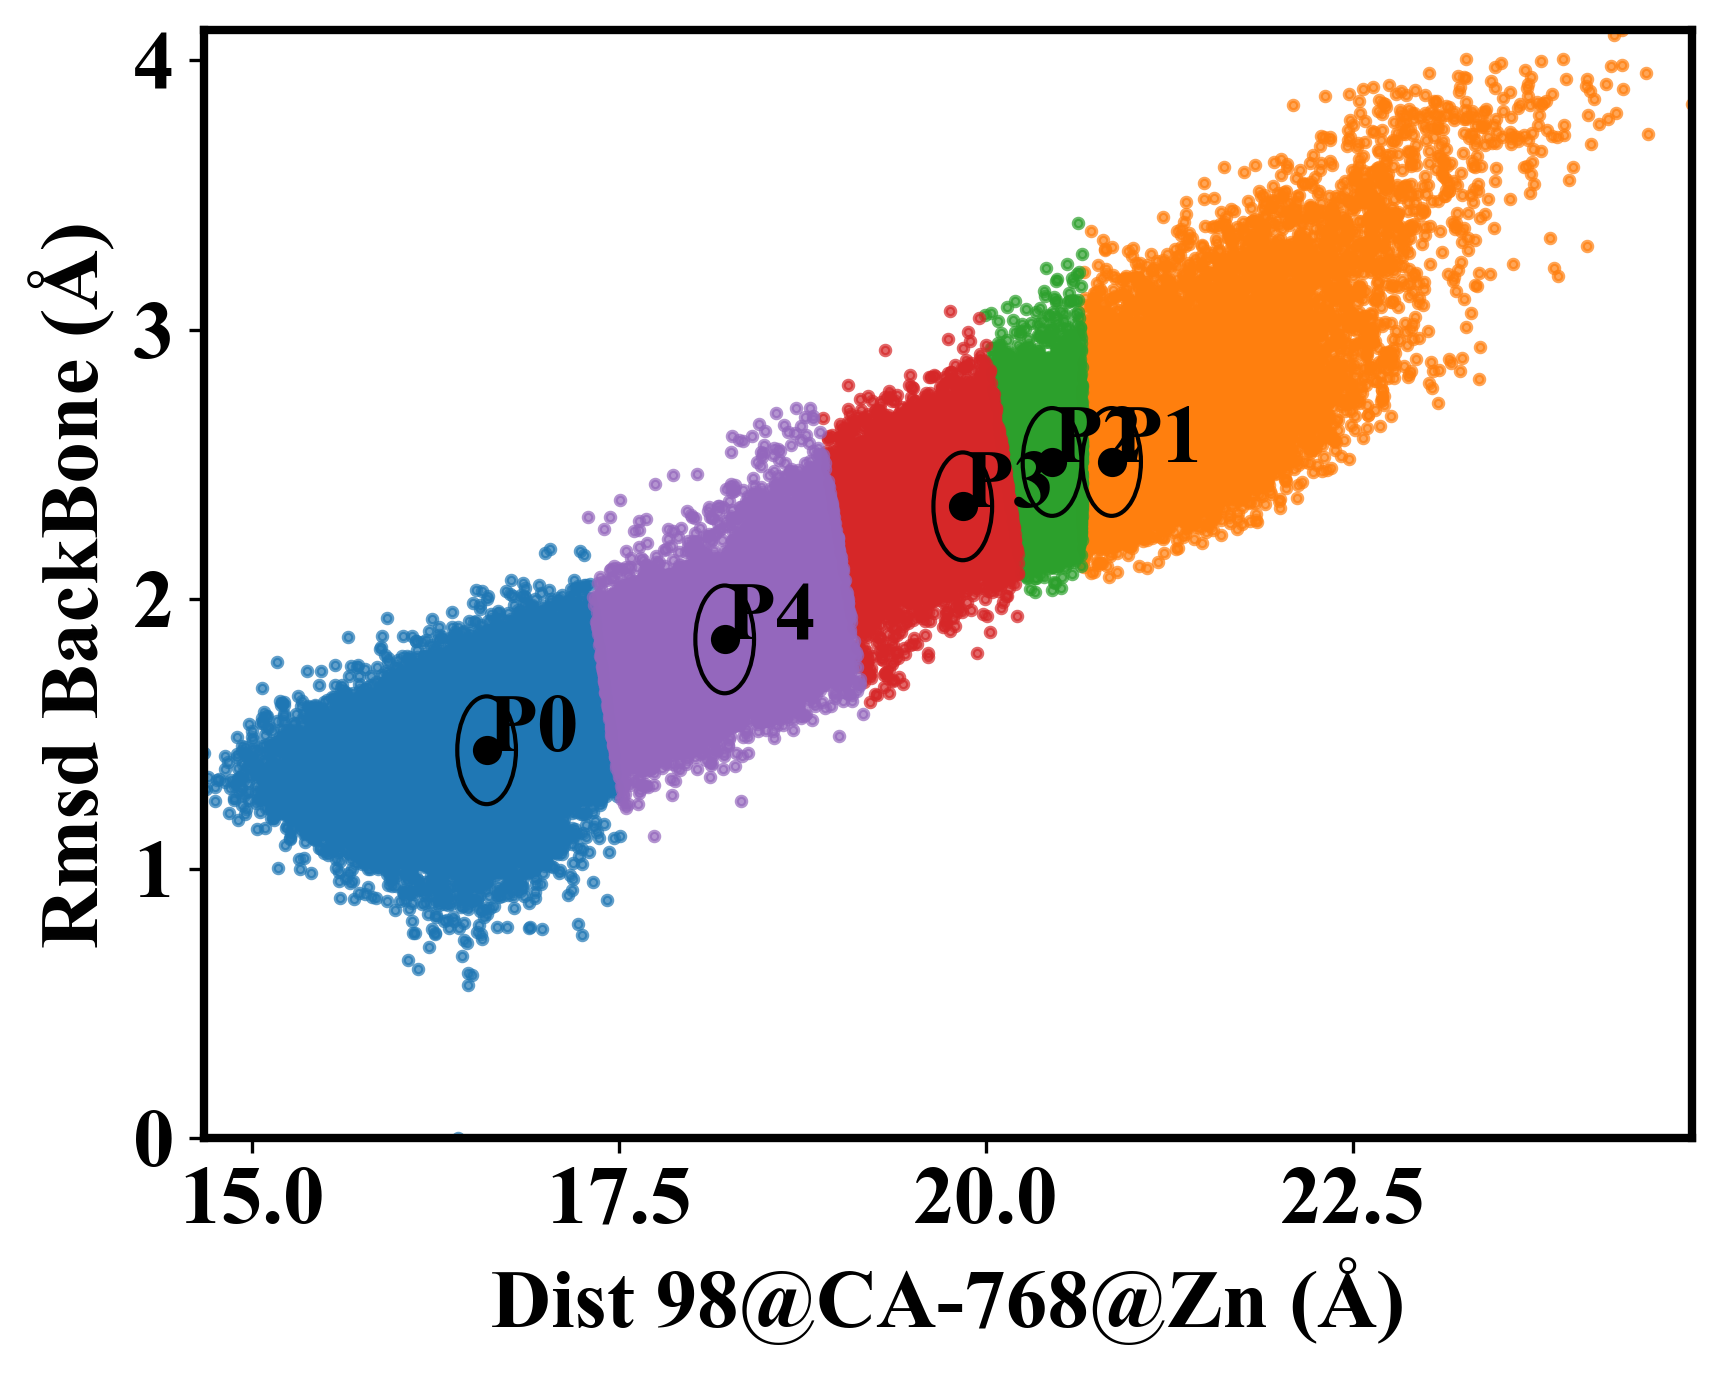

In [49]:
draw2DScatterCircle(df,slabel_0,myPeak,cutoff, "PCA-Peak-KNN",xlabel,ylabel)

Peak_Del_Index_List:
[2]

Start to cal Gibbs
G_max=4.18,G_min=0.00,GnoSample(Nan)=4.59,Gmax_nonan=4.59 

The selected Peak will be deleted, and re-KNN and draw PCA-Peak-KNN-selected



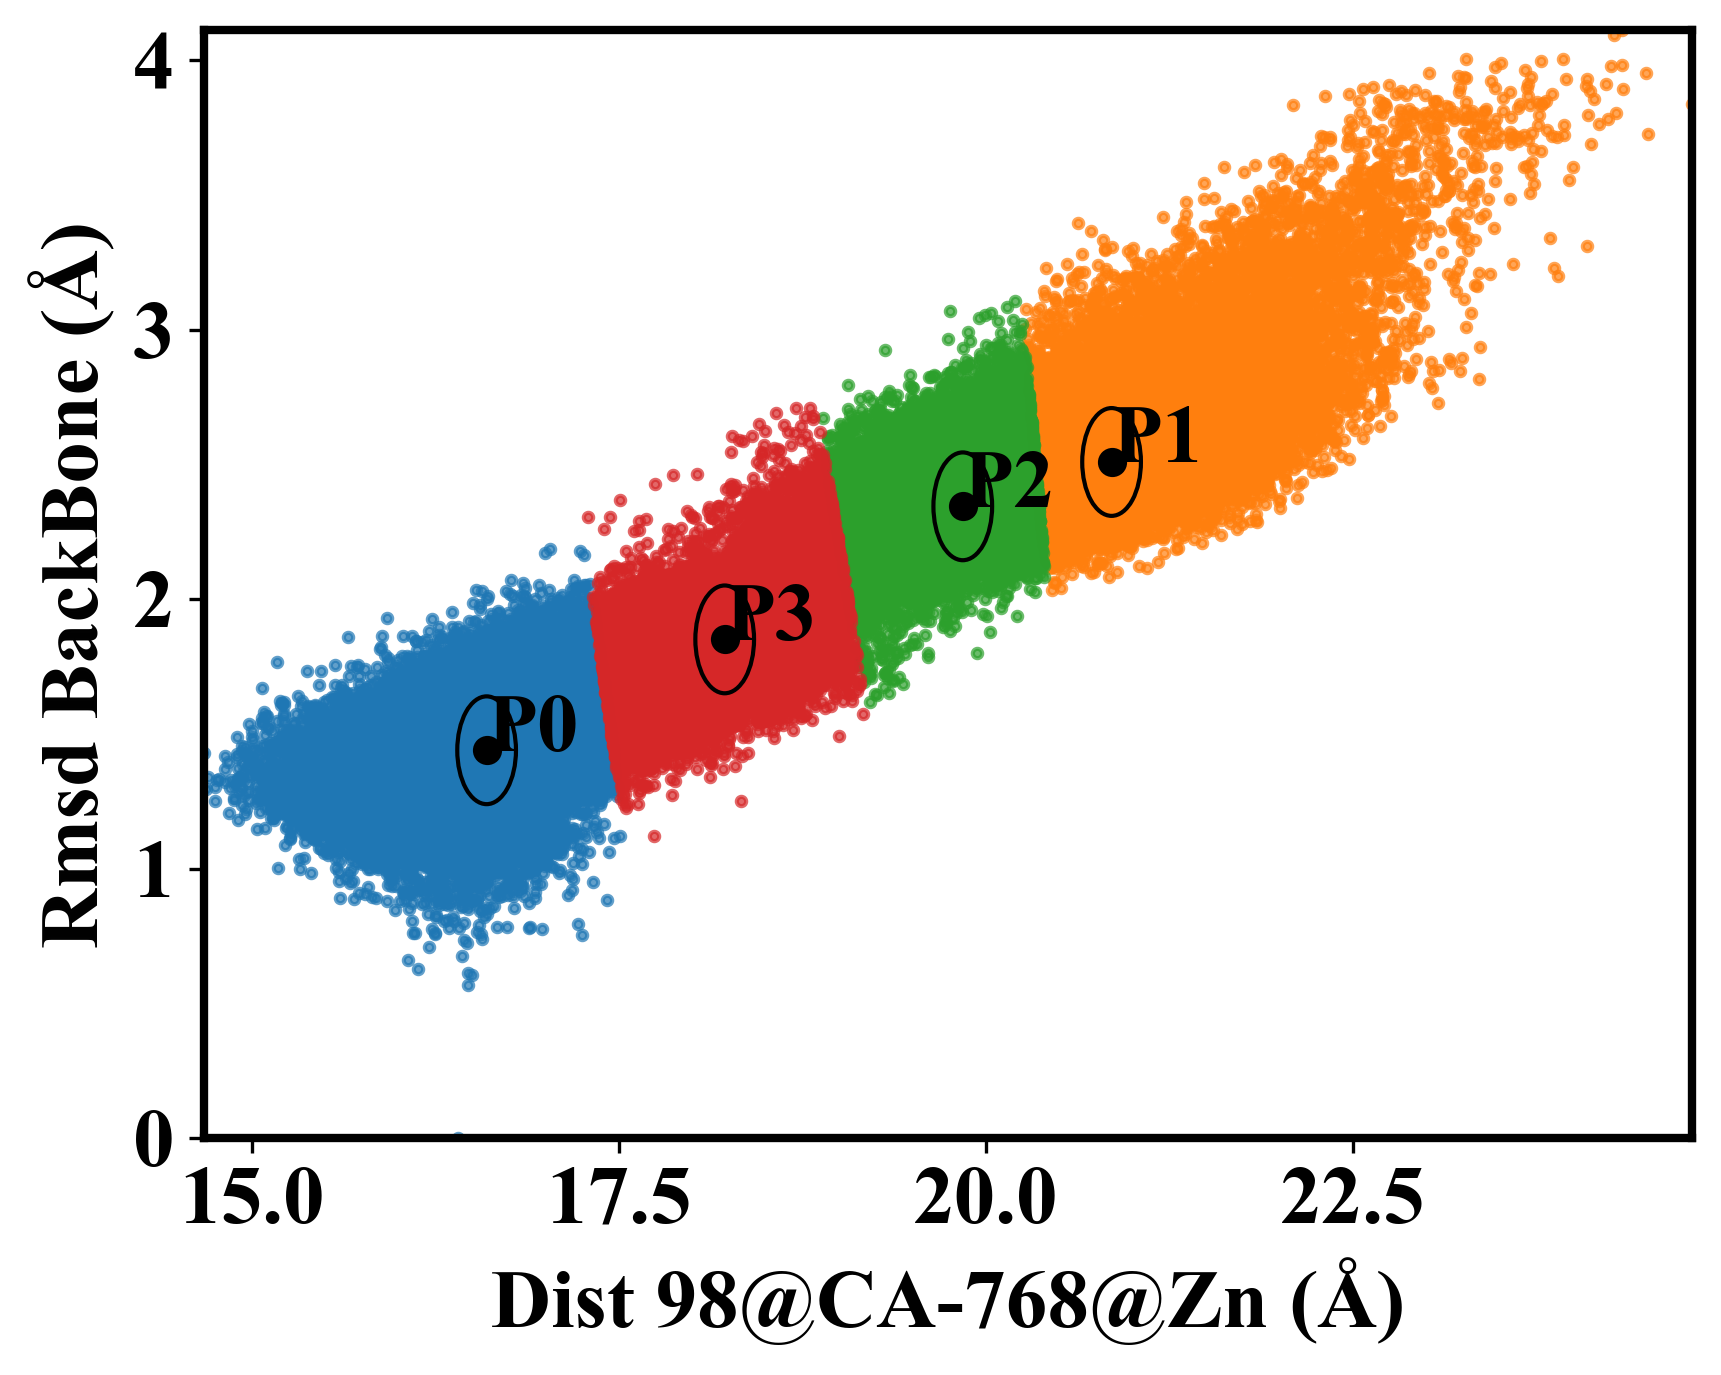

In [6]:
peak_del_index = [2]
print("Peak_Del_Index_List:")
print(peak_del_index)
print("")

print("Start to cal Gibbs")
Gibbs,g_peak = CalGibbs(myP[2],myPeak,T)
myPeak._g(g_peak)

# 这里进行杂峰的删除
print("The selected Peak will be deleted, and re-KNN and draw PCA-Peak-KNN-selected")
myPeak.delPeak(peak_del_index)
slabel_1,scut_1 = KNN(myPeak.x,myPeak.y,df,cutoff)
draw2DScatterCircle(df,slabel_1,myPeak,cutoff, "PCA-Peak-KNN-selected",xlabel,ylabel)
print("")
pd.DataFrame(myP[2]).T.to_csv("p.csv")

In [7]:
list(range(1,2000+1))[-1]

2000

In [8]:
# 
def SlidW(df, label,T):
    dat = df.copy(deep=True)
    dat[3] = label
    n_ct = len(set(label))
    # 构建转移矩阵
    #    - Cmatrix: 计数矩阵
    #    - Tmatrix: 转移概率矩阵
    Cmatrix = np.zeros(shape=(n_ct, n_ct))
    n_tran = 0
    for t in range(1,T+1):
        # 获得子序列
        sub_df = dat.iloc[::t,:]
        # 重排索引
        sub_df = sub_df.reset_index(drop=True)
        for i in range(sub_df.shape[0]-1):
            stata_1 = sub_df.iloc[i,3]
            stata_2 = sub_df.iloc[i+1,3]
            Cmatrix[stata_1][stata_2] += 1
            n_tran += 1
    return pd.DataFrame(Cmatrix/n_tran)
c1 = SlidW(df, slabel_1, 2000)

In [9]:
c1

,0,1,2,3
0,0.442574,0.000009,0.000450,0.022603
1,0.000000,0.195818,0.048025,0.000978
2,0.000106,0.049032,0.107403,0.016450
3,0.020041,0.001418,0.018513,0.076578


<AxesSubplot:>

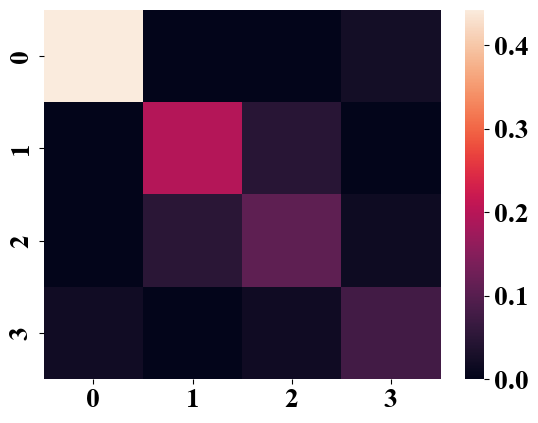

In [10]:
import seaborn as sns
sns.heatmap(c1)

In [11]:
df.iloc[::50,:]

,0,1,2
0,1.0,16.4057,0.0000
50,51.0,16.5351,0.8878
100,101.0,16.2018,0.9284
150,151.0,16.4667,0.9266
200,201.0,17.0973,0.9942
...,...,...,...
83750,83751.0,20.5416,2.5440
83800,83801.0,20.1720,2.7381
83850,83851.0,20.1934,2.7268
83900,83901.0,21.3792,2.5505


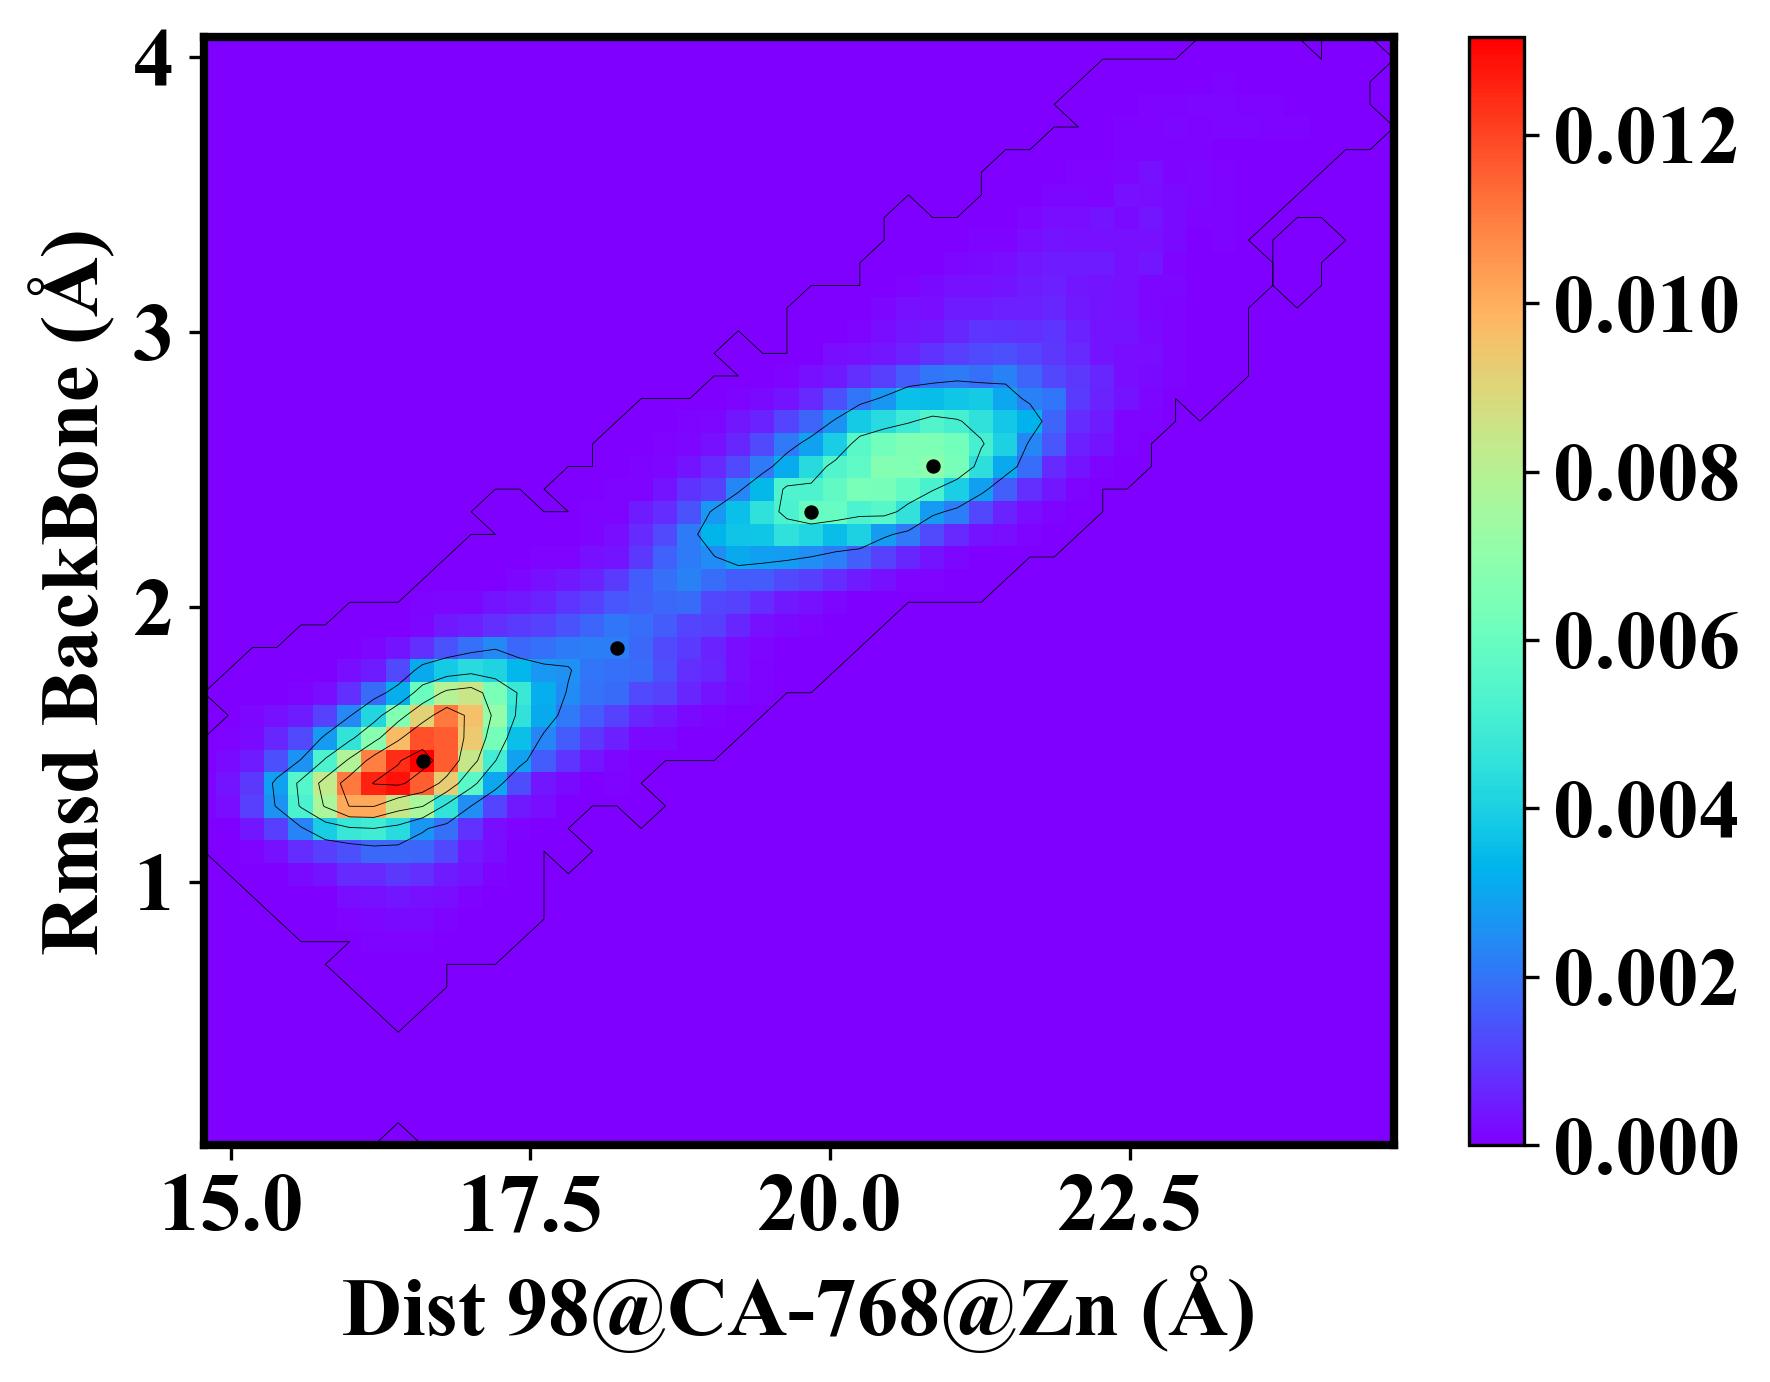

In [12]:
# 绘制未插值的图
#draw2DGibbs((myP[0],myP[1],myP[2]),mycmp,myPeak,"P-ori",xlabel,ylabel)
draw2DGibbs((myP[0],myP[1],myP[2]),mycmp,myPeak,"P-ori",xlabel,ylabel)

Gibbs_MAX=4.59,Gibbs_MIN=0.00
Gibbs InterNUM_ggd:
Gibbs_MAX=4.59,Gibbs_MIN=0.00


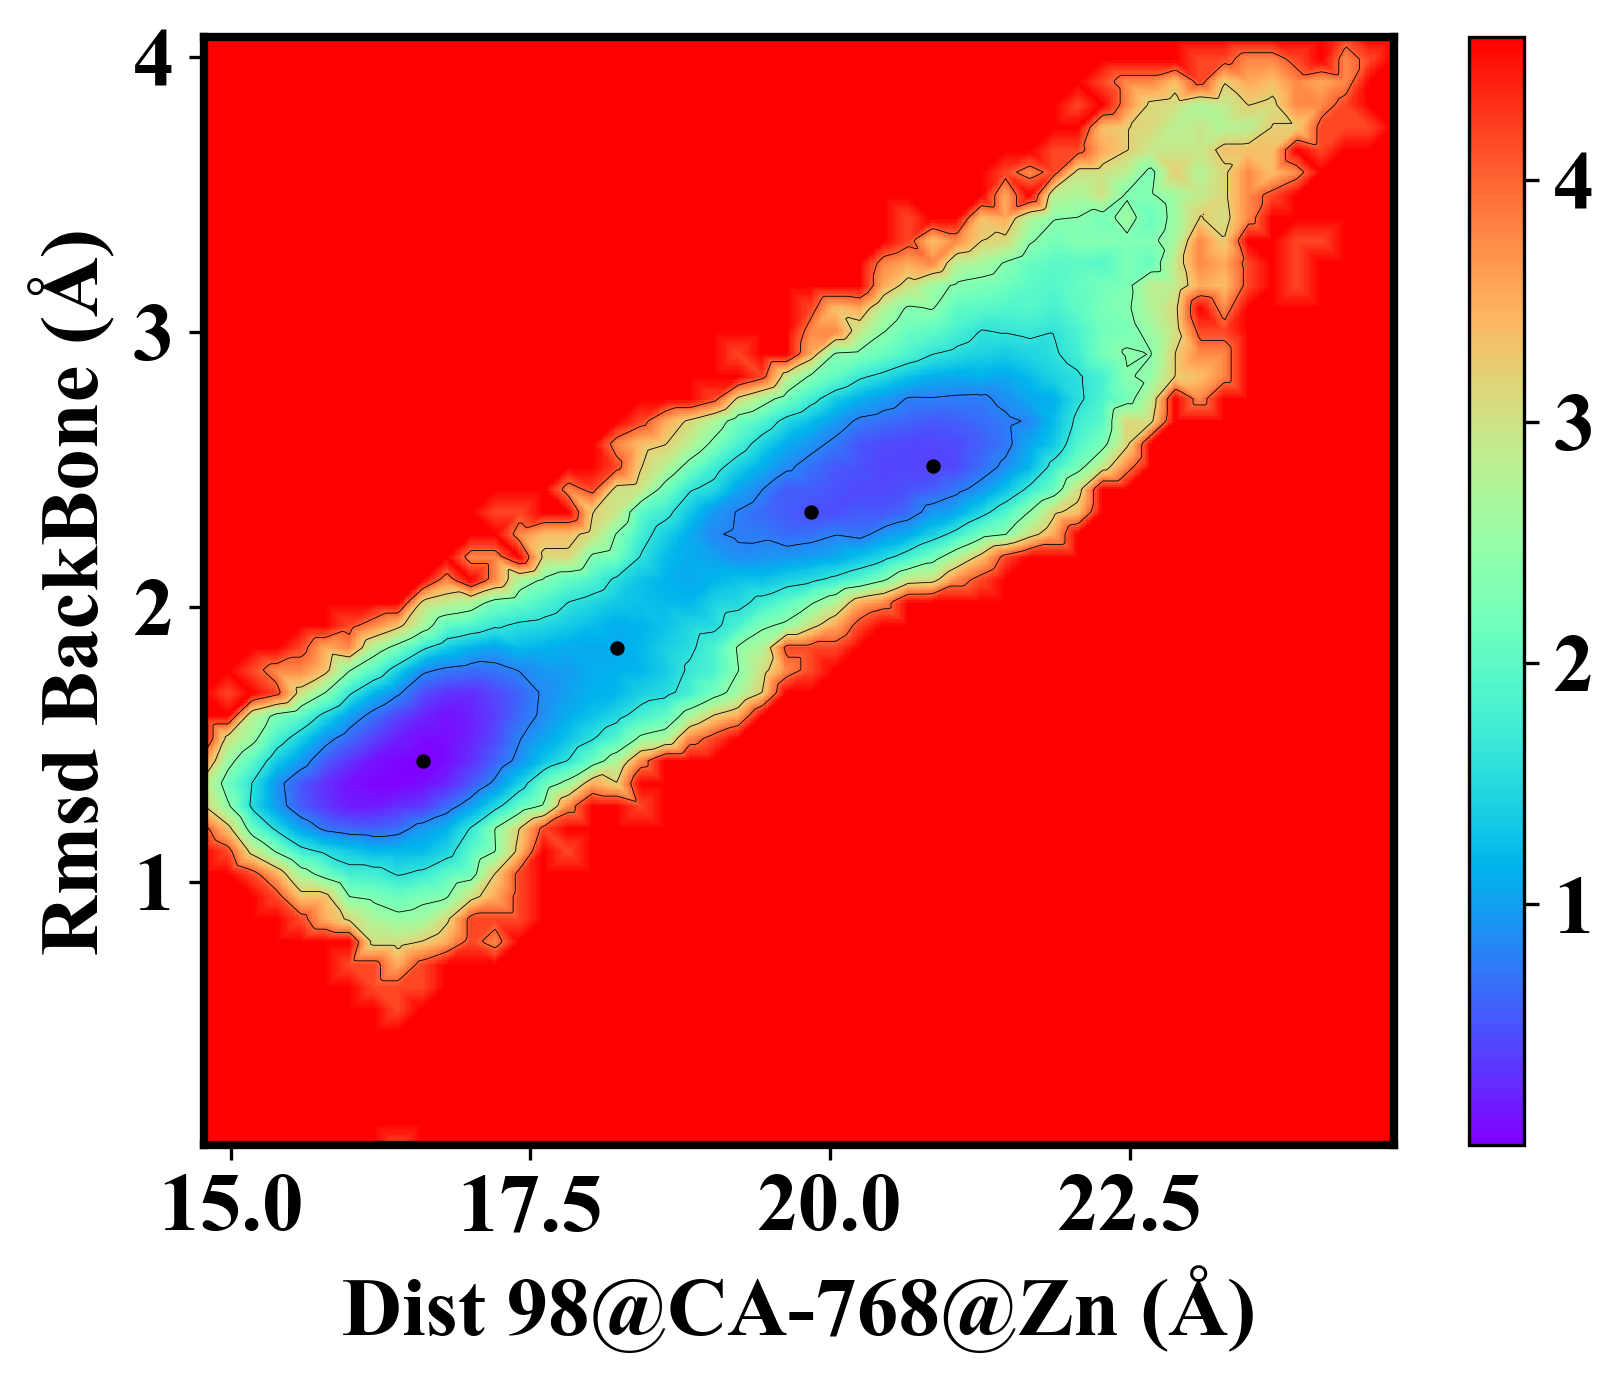

In [13]:
# 绘制插值的图
#draw2DGibbs((myP[0],myP[1],myP[2]),mycmp,myPeak,"P-ori",xlabel,ylabel)
G_ggd = G_InterNUM_ggd(myP,Gridnum,Gibbs)
draw2DGibbs(G_ggd,mycmp,myPeak,"Gibbs",xlabel,ylabel)

/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'zdim'
  """


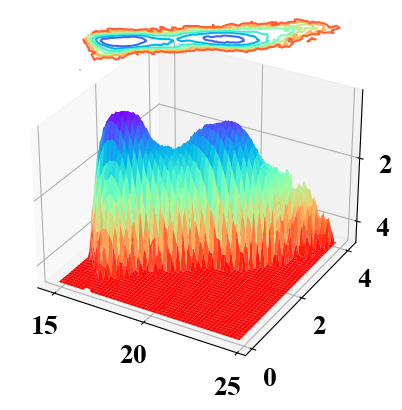

In [42]:
fig = plt.figure()  #定义新的三维坐标轴
ax3 = plt.axes(projection='3d')
ax3.plot_surface(G_ggd[0],G_ggd[1],G_ggd[2],cmap='rainbow')
ax3.invert_zaxis()
ax3.contour(G_ggd[0],G_ggd[1],G_ggd[2], zdim='z',offset=-2,cmap="rainbow")   
plt.show()

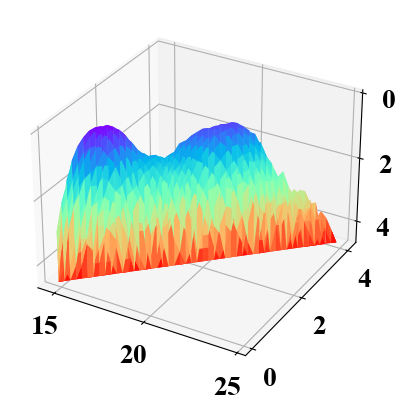

In [44]:
fig = plt.figure()  #定义新的三维坐标轴
ax3 = plt.axes(projection='3d')
ax3.plot_surface(myP[0],myP[1],Gibbs,cmap='rainbow')
ax3.invert_zaxis()
#ax3.contour(myP[0],myP[1],Gibbs, zdim='z',offset=-2,cmap="rainbow")   
plt.show()

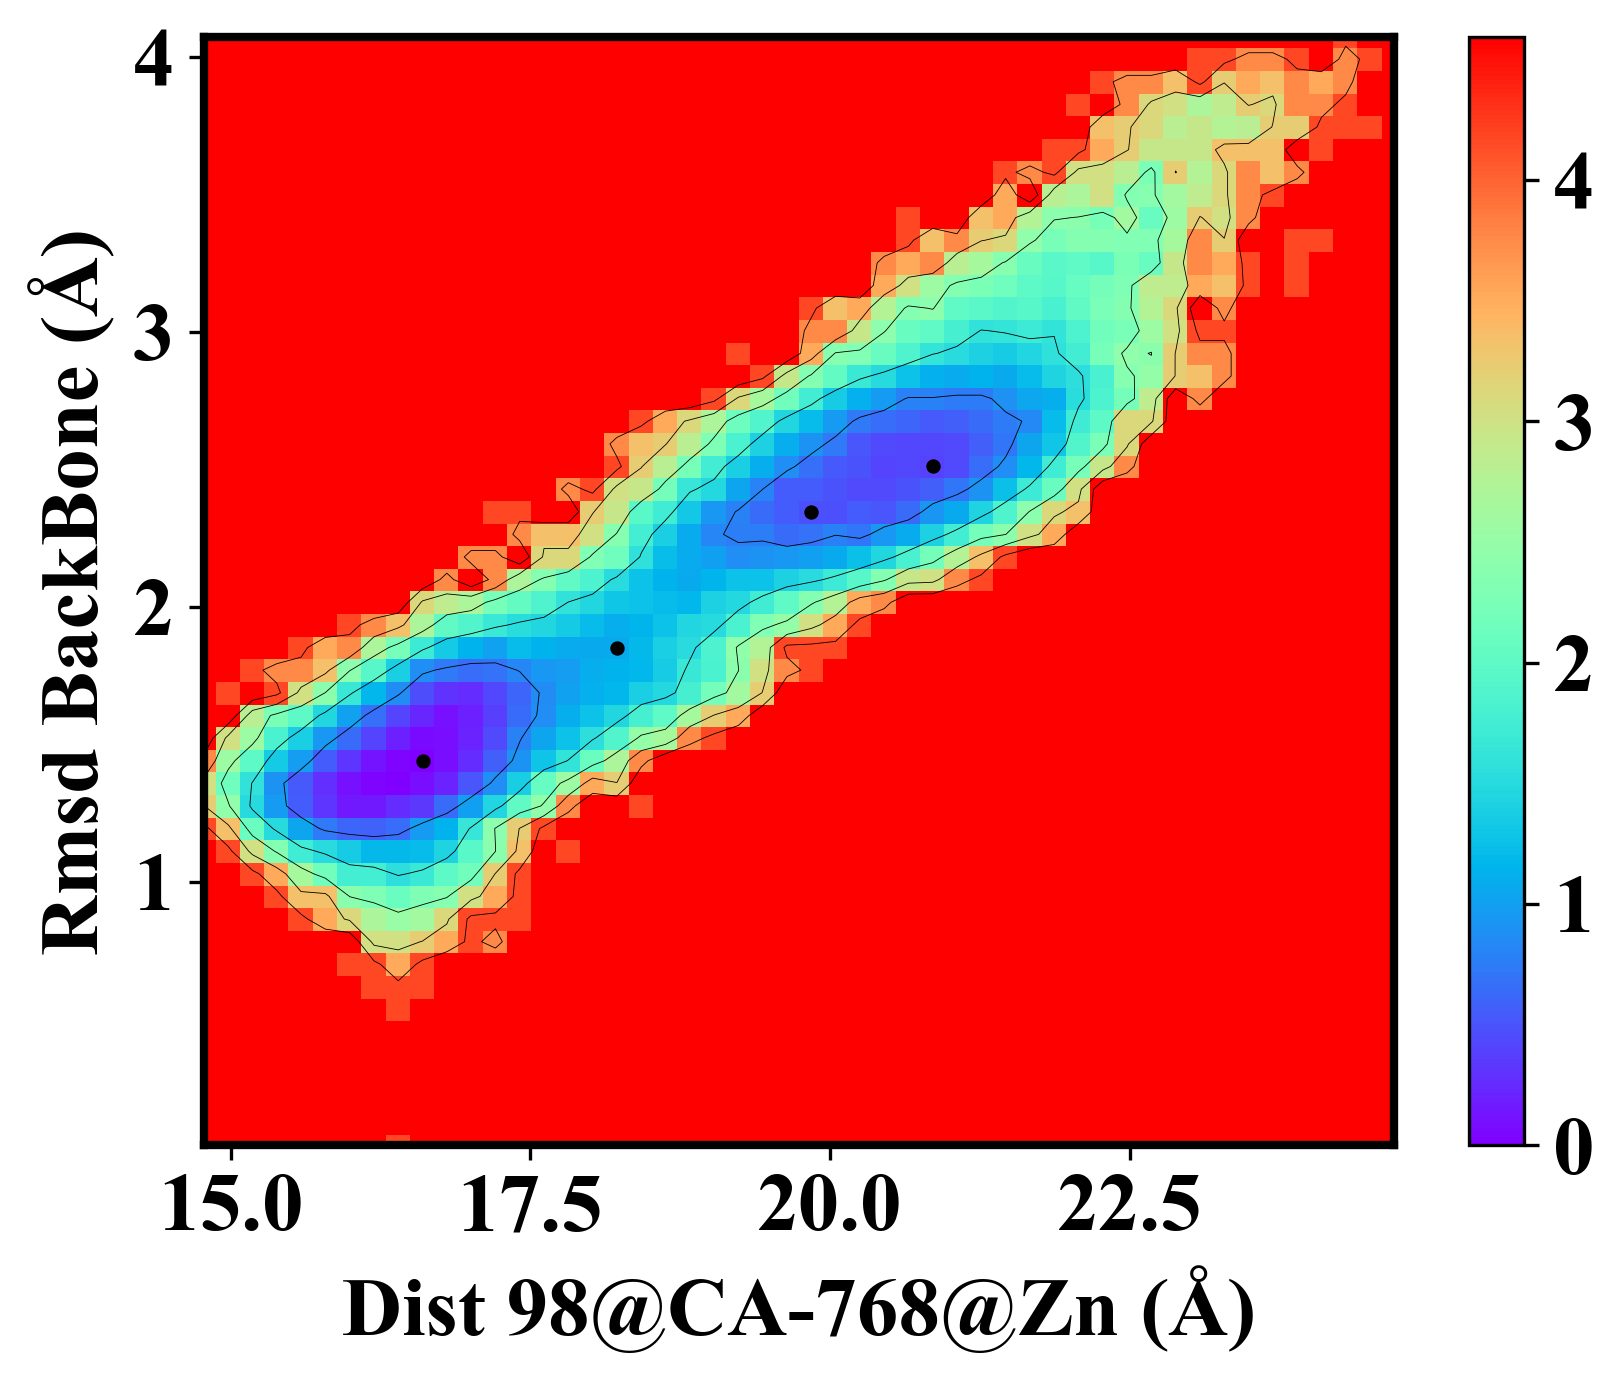

In [41]:
draw2DGibbs((myP[0],myP[1],Gibbs),mycmp,myPeak,"P-ori",xlabel,ylabel)

In [15]:
myPeak.ij

array([[17,  9],
       [30, 30],
       [28, 25],
       [22, 17]])

In [77]:
def cSign(XY):
    #Sign = np.full(XY.shape,None).astype("str")
    dic = {}    
    ij = XY.shape
    for i in range(ij[0]):
        for j in range(ij[1]):
            dic["{}_{}".format(i,j)] = {}
            if i+1 in range(ij[0]) and j-1 in  range(ij[1]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i+1,j-1)] =  XY[i+1][j-1] - XY[i][j]
            if i+1 in range(ij[0]) and j+1 in  range(ij[1]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i+1,j+1)] =  XY[i+1][j+1] - XY[i][j]
            if i+1 in range(ij[0]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i+1,j )]=  XY[i+1][j] - XY[i][j]
            if i-1 in range(ij[0]) and j-1 in range(ij[1]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i-1,j-1)] = XY[i-1][j-1] - XY[i][j]
            if i-1 in range(ij[0]) and j+1 in range(ij[1]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i-1,j+1)] = XY[i-1][j+1] - XY[i][j]
            if i-1 in range(ij[0]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i-1,j)] = XY[i-1][j] - XY[i][j]
            if j-1 in range(ij[1]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i,j-1)] =   XY[i][j-1] - XY[i][j]
            if j+1 in range(ij[1]):
                dic["{}_{}".format(i,j)]["{}_{}".format(i,j+1)] =   XY[i][j+1] - XY[i][j]
    
    return dic 

import heapq
import math

def init_distance(graph, start):
    distance = {start :0}
    for vertex in graph:
        if vertex != start:
            distance[vertex] = math.inf
    return distance


def dijkstra(graph, start):
    pqueue = []
    heapq.heappush(pqueue, (0, start))
    seen = set()
    parent = {start: None}
    distance = init_distance(graph, start)

    while (len(pqueue) > 0):
        pair = heapq.heappop(pqueue)
        dist = pair[0]
        vertex = pair[1]
        seen.add(vertex)

        nodes = graph[vertex].keys()

        for w in nodes:
            if w not in seen:
                if dist + graph[vertex][w] < distance[w]:
                    heapq.heappush(pqueue, (dist + graph[vertex][w], w))
                    parent[w] = vertex
                    distance[w] = dist - graph[vertex][w]
    return parent, distance

In [78]:
g = cSign(G_ggd[2])

In [73]:
ij = peak_local_max(-G_ggd[2], num_peaks=2)


In [19]:
# 检验新找到的极值点与旧极值点的差异
X,Y,Z = G_ggd
print("P0-new = ({:.2f},{:.2f})".format(X[ij[0][0], ij[0][1]], Y[ij[0][0], ij[0][1]]))
print("P0-old = ({:.2f},{:.2f})".format(myPeak.x[0], myPeak.y[0]))
print("P1-new = ({:.2f},{:.2f})".format(X[ij[1][0], ij[1][1]], Y[ij[1][0], ij[1][1]])) 
print("P1-old = ({:.2f},{:.2f})".format(myPeak.x[1], myPeak.y[1]))

P0-new = (16.59,1.44)
P0-old = (16.60,1.44)
P1-new = (20.85,2.51)
P1-old = (20.86,2.51)


In [79]:
traj = []
traj_dis = []
start = "{}_{}".format(ij[0][0], ij[0][1])
#end = "224_427"
#end = "224_71"
#end = "183_101"
#end = "153_153"
distance = 0
par, dis = dijkstra(g, start)
for end in ["{}_{}".format(ij[1][0], ij[1][1])]:   
    while end != None:
        traj.append([eval(i) for i in end.split("_")])
        end = par[end]


In [82]:
#for k in g.keys():
#    var = g[k]
#    for k2 in g[k].keys():
#        if g[k][k2] <= 0:
#            print(k,k2,g[k][k2])

In [83]:
"{}_{}".format(ij[1][0], ij[1][1])

'306_305'

In [84]:
dis["{}_{}".format(ij[1][0], ij[1][1])]

0.38903453950734096

In [87]:
traj

[[306, 305],
 [306, 304],
 [306, 303],
 [306, 302],
 [306, 301],
 [306, 300],
 [306, 299],
 [306, 298],
 [306, 297],
 [306, 296],
 [306, 295],
 [306, 294],
 [306, 293],
 [306, 292],
 [306, 291],
 [306, 290],
 [306, 289],
 [306, 288],
 [306, 287],
 [306, 286],
 [305, 285],
 [304, 285],
 [303, 285],
 [302, 285],
 [301, 285],
 [300, 285],
 [299, 285],
 [298, 285],
 [297, 285],
 [296, 285],
 [295, 284],
 [295, 283],
 [295, 282],
 [295, 281],
 [295, 280],
 [295, 279],
 [295, 278],
 [295, 277],
 [295, 276],
 [295, 275],
 [295, 274],
 [294, 273],
 [293, 272],
 [292, 271],
 [291, 270],
 [290, 269],
 [289, 268],
 [288, 267],
 [287, 266],
 [286, 265],
 [285, 264],
 [285, 263],
 [285, 262],
 [285, 261],
 [285, 260],
 [285, 259],
 [285, 258],
 [285, 257],
 [285, 256],
 [285, 255],
 [286, 255],
 [287, 255],
 [288, 255],
 [289, 255],
 [290, 255],
 [291, 255],
 [292, 255],
 [293, 255],
 [294, 254],
 [295, 253],
 [295, 252],
 [295, 251],
 [295, 250],
 [295, 249],
 [295, 248],
 [295, 247],
 [295, 246],

In [21]:
"""
traj = []
start = "{}_{}".format(ij[0][0], ij[0][1])
#end = "224_427"
#end = "224_71"
#end = "183_101"
#end = "153_153"
par, dis = dijkstra(g, start)
for end in ["{}_{}".format(ij[1][0], ij[1][1])]:   
    while end != None:
        traj.append([eval(i) for i in end.split("_")])
        end = par[end]
"""

'\ntraj = []\nstart = "{}_{}".format(ij[0][0], ij[0][1])\n#end = "224_427"\n#end = "224_71"\n#end = "183_101"\n#end = "153_153"\npar, dis = dijkstra(g, start)\nfor end in ["{}_{}".format(ij[1][0], ij[1][1])]:   \n    while end != None:\n        traj.append([eval(i) for i in end.split("_")])\n        end = par[end]\n'

In [88]:
def drawPATH(xyz,cname,traj, select_traj,ij,xlabel, ylabel):
    # 绘制概率密度曲线
    X,Y,Z = xyz
    fig,ax = plt.subplots(dpi=300)
    # 设置边框
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)

    ax.set_xlim(X.min(),X.max())
    ax.set_ylim(Y.min(),Y.max())
    ax.set_xlabel("{}".format(xlabel))
    ax.set_ylabel("{}".format(ylabel))
    C=plt.contour(X,Y,Z,5,colors='black',linewidths= 0.2)  #生成等值线图
    plt.contourf(X,Y,Z,5,alpha=0.2)
    Pcolor= plt.pcolor(X, Y, Z
                       ,shading='auto',cmap=cname
                       ,norm = colors.TwoSlopeNorm(vmin=Z.min(), vcenter=(Z.max()-Z.min())/2, vmax=Z.max()))
    plt.colorbar(Pcolor)
    x_ = [X[i[0],i[1]] for i in traj]
    y_ = [Y[i[0],i[1]] for i in traj]
    plt.plot(x_,y_,color = "white", linestyle = "--", linewidth = 1.5)
    plt.scatter([X[ij[0][0], ij[0][1]], X[ij[1][0], ij[1][1]] ] , [Y[ij[0][0], ij[0][1]], Y[ij[1][0], ij[1][1]]],c = "black")
    for i in select_traj:
        plt.scatter([X[i[0], i[1]]], [Y[i[0], i[1]]], c = "black")
    #plt.scatter([X[285,255], X[295,276], X[305,285]], [Y[285,255], Y[295,276], Y[305,285]],c = "black")
    plt.savefig("colorbar1.jpg",dpi=300)


In [89]:
# 从路径中寻找与旧极值点最接近的路径点
from math import sqrt
X,Y,Z = G_ggd
peak_err = 0.001
# 排除P0与P1
dic_ = {}
for i,t in enumerate(myPeak.x[2:]):
    old_x = t
    old_y = myPeak.y[2+i]
    dic_["P{}".format(i+2)] = {}
    for tra in traj:
        new_x = X[tra[0], tra[1]]
        new_y = Y[tra[0], tra[1]]
        dis = sqrt(pow(new_x-old_x, 2)+pow(new_y-old_y, 2))
        dic_["P{}".format(i+2)]["{}-{}".format(*tra)] = dis


In [90]:
select_traj = []
for p in dic_.keys():
    p_sort = sorted(dic_[p].items(),  key=lambda d: d[1], reverse=False)
    print("{}: {}, distance between old peak and new peak is {}".format(p, *p_sort[0]))
    select_traj.append([eval(i) for i in p_sort[0][0].split("-")])

P2: 305-285, distance between old peak and new peak is 0.005008891255274323
P3: 285-255, distance between old peak and new peak is 0.008209104305491035
P4: 225-173, distance between old peak and new peak is 0.008125233446222372


In [91]:
select_traj

[[305, 285], [285, 255], [225, 173]]

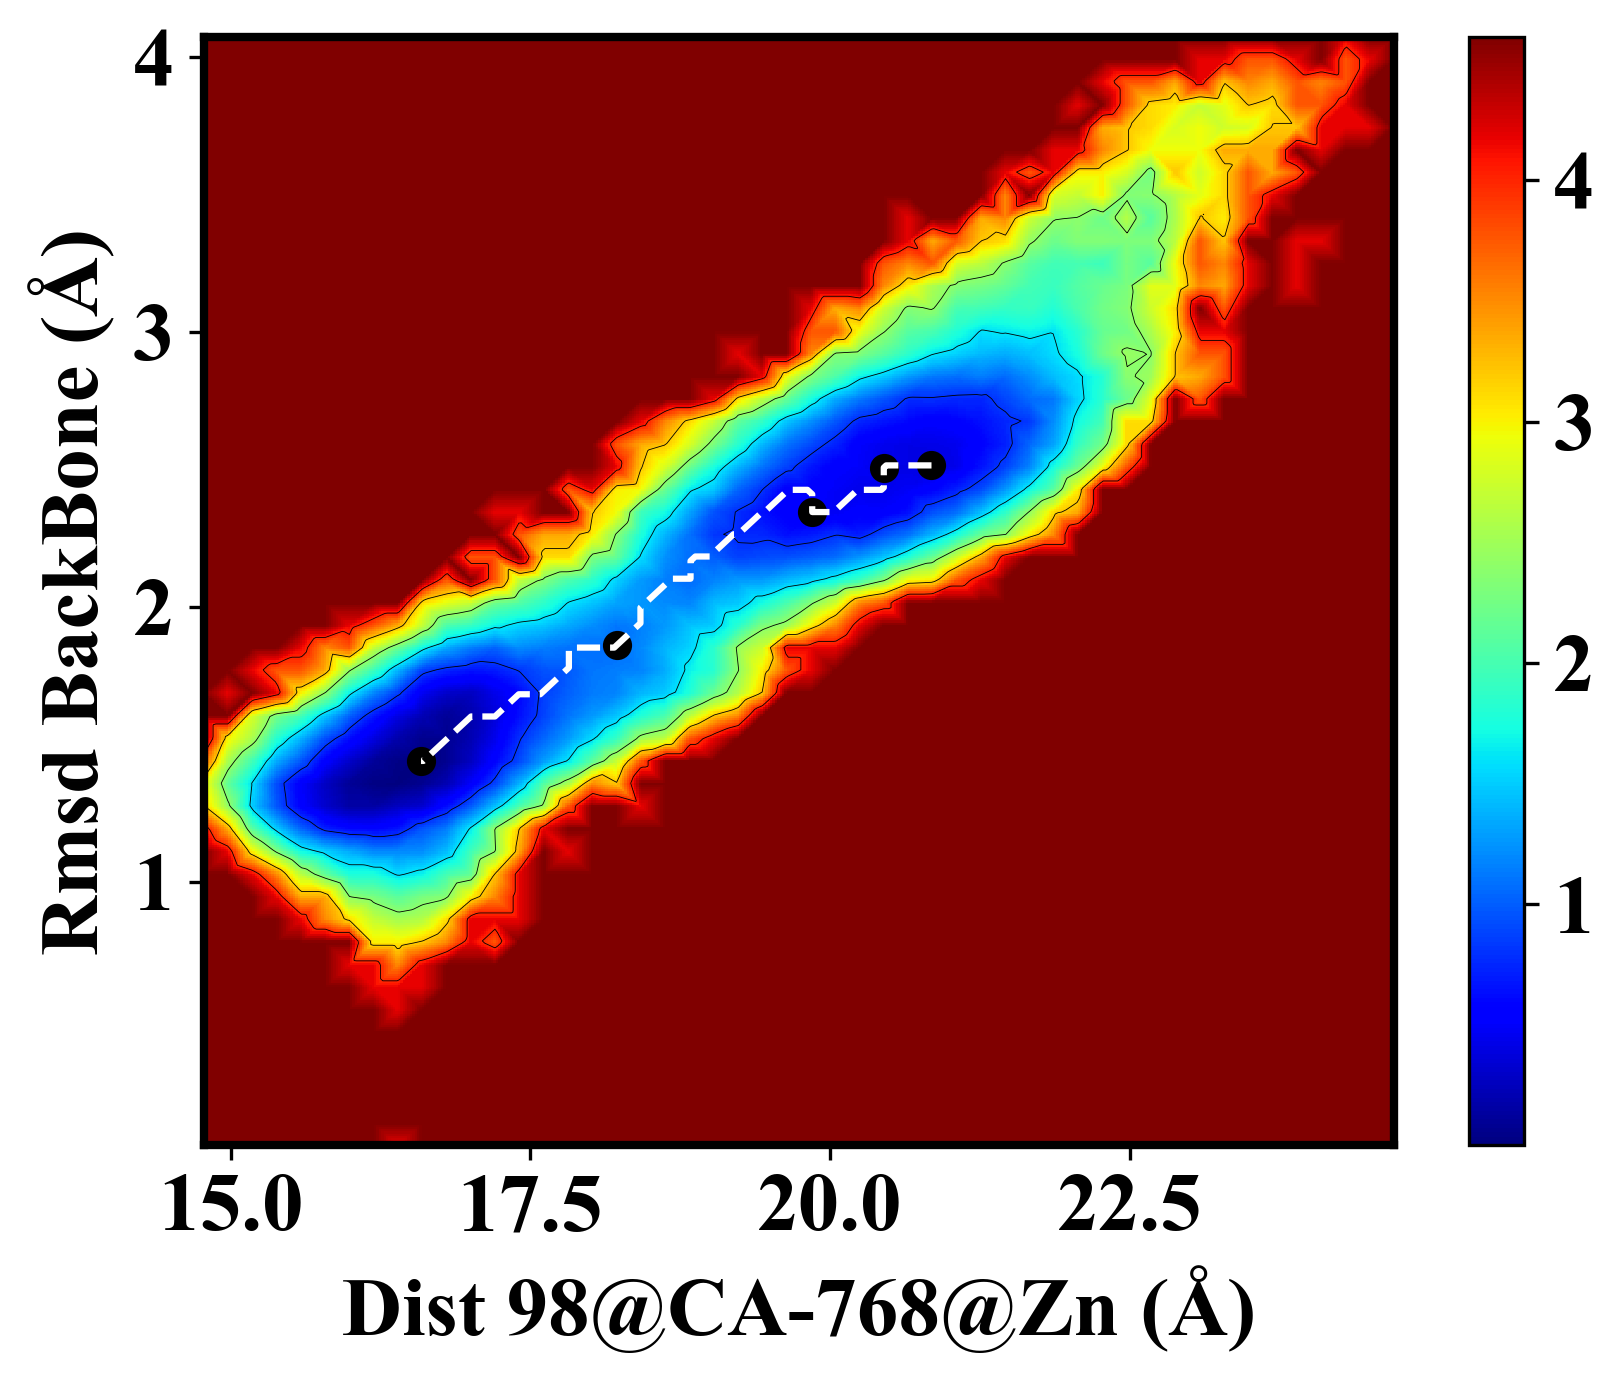

In [92]:
drawPATH(G_ggd,"jet",traj,select_traj,ij,xlabel, ylabel)

In [27]:
def distribution1(data, nbins):
    out = []
    hist, bins = np.histogram(data, bins = nbins, density= True)
    for i, i_t in enumerate(bins[:-1]):
        var = (bins[i+1] + i_t)/2
        out.append(var)
    return np.array(out), hist

def drawPATH2(xyz,x_data,y_data, cname,traj,select_traj,ij,xlabel, ylabel):
    # 绘制概率密度曲线
    X,Y,Z = xyz
    fig = plt.figure(figsize = (6,6),dpi=300)
    grid = plt.GridSpec(4,4, hspace=0, wspace = 0)
    main_ax = fig.add_subplot(grid[:-1,1:])
    y_ax = fig.add_subplot(grid[:-1,0], sharey = main_ax)
    x_ax = fig.add_subplot(grid[-1,1:], sharex = main_ax)

    d1 = distribution1(x_data, 50)
    d2 = distribution1(y_data, 50)

    y_ax.set_xlim(0,1.5)
    x_ax.set_ylim(0,0.6)
    y_data_ = np.array(list(range(84000))) / 60000
    x_data_ = np.array(list(range(84000))) / 168000


    main_ax.set_xlim(X.min(),X.max())
    main_ax.set_ylim(Y.min(),Y.max())

    x_ax.plot(d1[0], d1[1], c = "black", linewidth= 0.2)
    x_ax.plot(x_data, x_data_, c = "#0014FF", linewidth= 0.8)
    x_ax.fill_between(d1[0], 0 ,d1[1],facecolor = "#800000", alpha= 0.9 )
    x_ax.invert_yaxis()
    y_ax.plot(d2[1], d2[0], c = "black", linewidth= 0.2)
    y_ax.plot(y_data_, y_data, c = "#0014FF", linewidth= 0.8)
    y_ax.fill_between(d2[1], 0 ,d2[0],facecolor = "#800000", alpha= 0.9 )
    y_ax.invert_xaxis()
 
    #x_ax.set_xticks([])
    x_ax.set_yticks([])
    y_ax.set_xticks([])
    #y_ax.set_yticks([])

    # 设置边框
    for i in [main_ax, x_ax, y_ax]:
        i.spines['bottom'].set_linewidth(2)
        i.spines['top'].set_linewidth(2)
        i.spines['left'].set_linewidth(2)
        i.spines['right'].set_linewidth(2)

    #main_ax.set_xticks([])
    #main_ax.set_yticks([])
    #main_ax.set_yticklabels([])
    #main_ax.set_xticklabels([])
    x_ax.set_xlabel("{}".format(xlabel))
    y_ax.set_ylabel("{}".format(ylabel))
  
    C=main_ax.contour(X,Y,Z,5,colors='black',linewidths= 0.2)  #生成等值线图
    main_ax.contourf(X,Y,Z,5,alpha=0.2)
    Pcolor= main_ax.pcolor(X, Y, Z
                       ,shading='auto',cmap=cname
                       ,norm = colors.TwoSlopeNorm(vmin=Z.min(), vcenter=(Z.max()-Z.min())/2, vmax=Z.max()))
    x_ = [X[i[0],i[1]] for i in traj]
    y_ = [Y[i[0],i[1]] for i in traj]
    main_ax.plot(x_,y_,color = "white", linestyle = "--", linewidth = 1.5)
    main_ax.scatter([X[ij[0][0], ij[0][1]], X[ij[1][0], ij[1][1]] ] , [Y[ij[0][0], ij[0][1]], Y[ij[1][0], ij[1][1]]],c = "black")
    for i in select_traj:
        main_ax.scatter([X[i[0], i[1]]], [Y[i[0], i[1]]], c = "black")

    plt.savefig("./G-P-1.jpg",dip=300)


/home/ubuntu/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dip" which is no longer supported as of 3.3 and will become an error two minor releases later


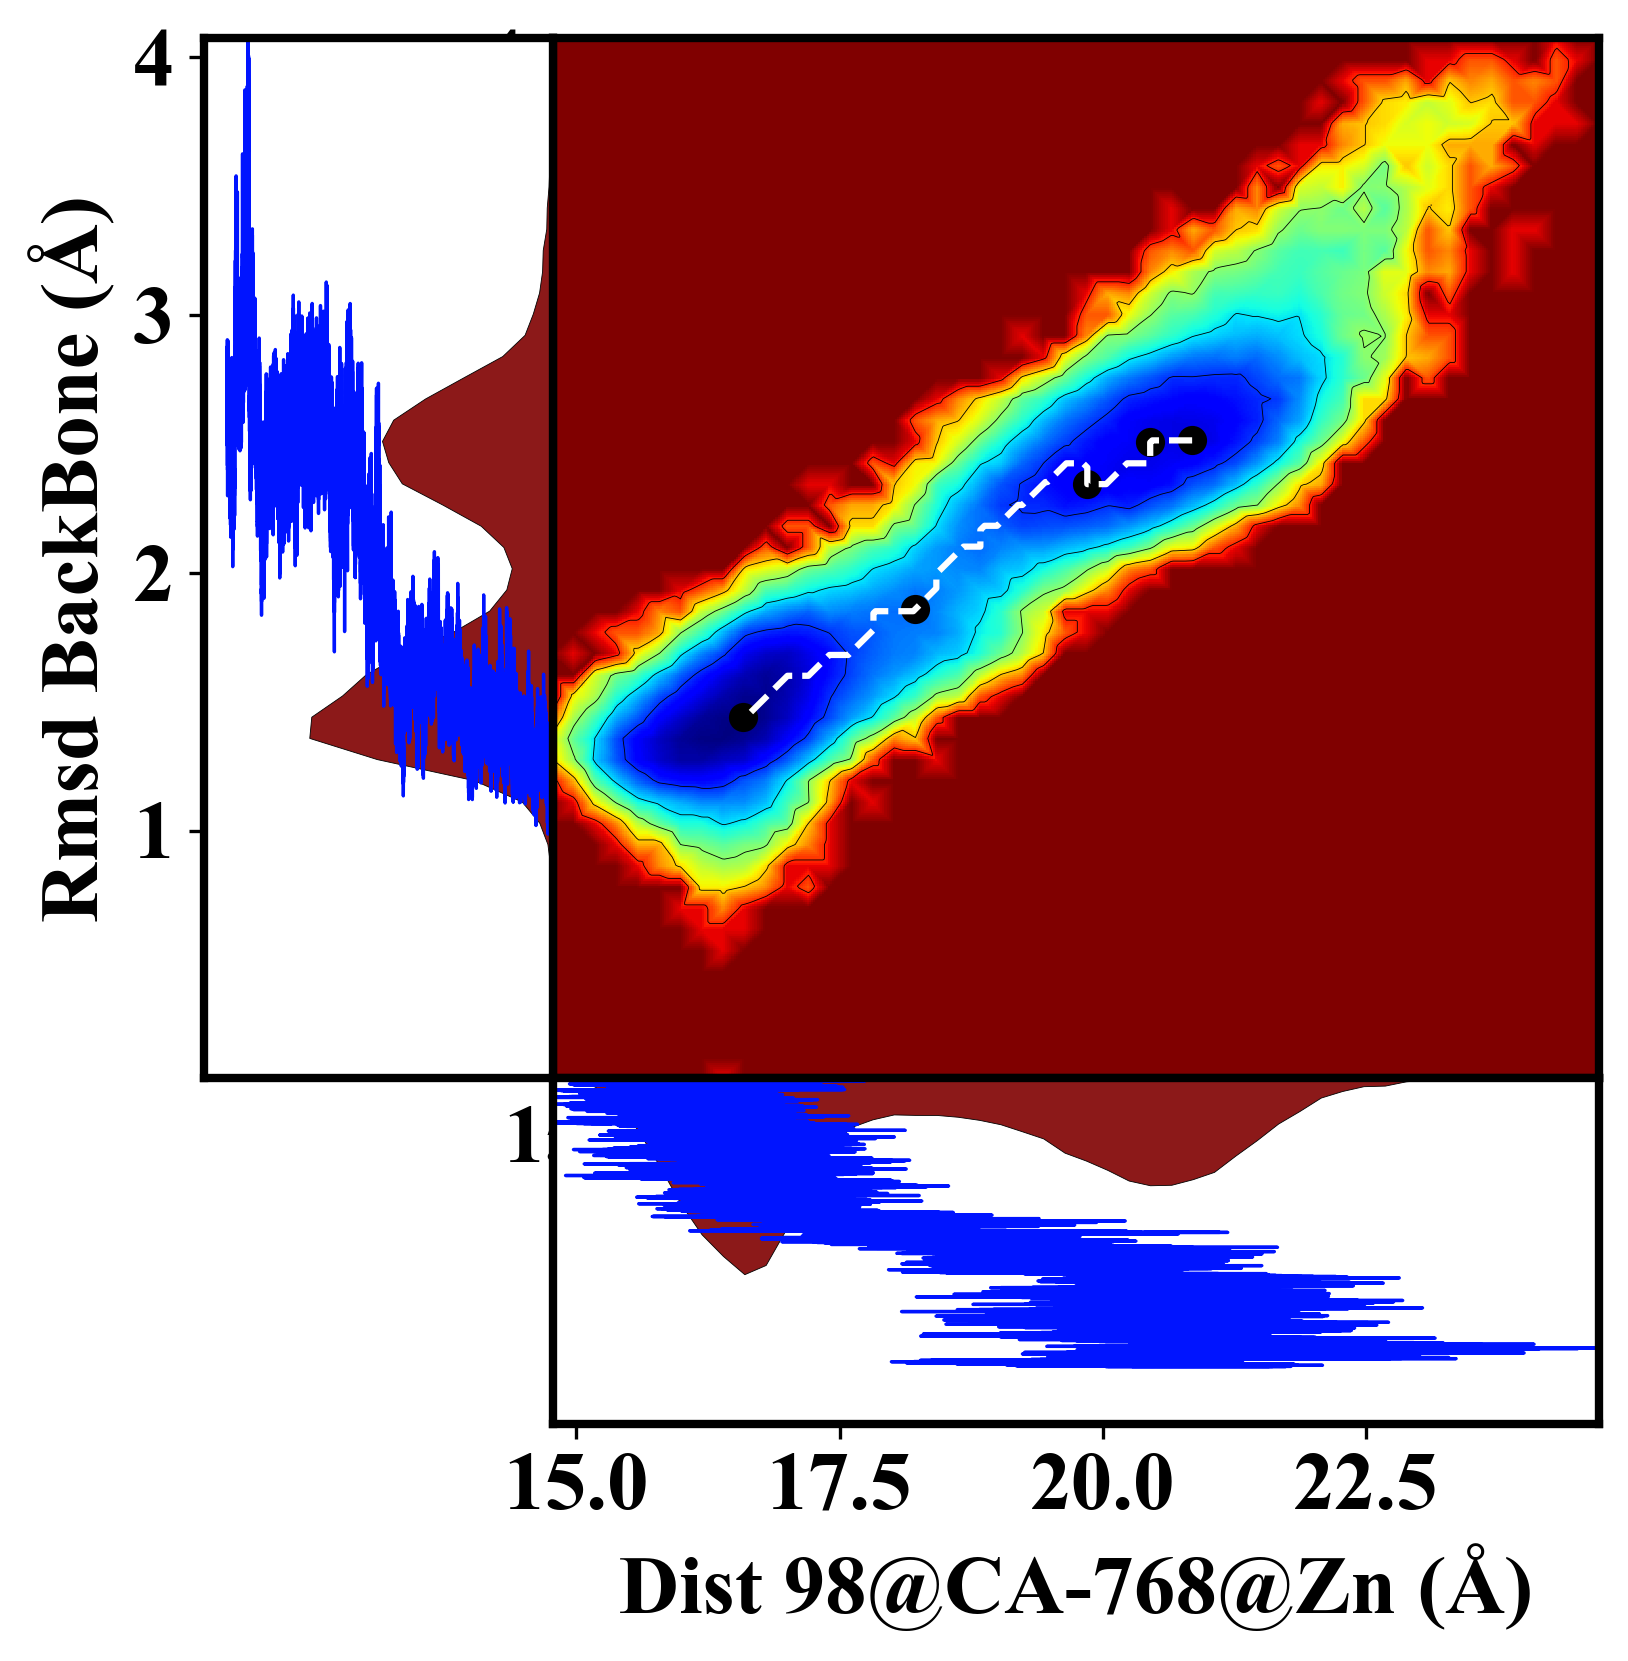

In [93]:
drawPATH2(G_ggd,df[1].to_numpy(),df[2].to_numpy(),"jet",traj,select_traj,ij,xlabel, ylabel)

In [29]:
CTframe_out = CTframe(df,slabel_1,scut_1)
sF = 1
PrintCTframe(CTframe_out, sF, "frame-knn.log")